In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import skimage

In [2]:
def cv_show(name,img):
    img = np.flip(img,2)
    cv.imshow(name,img)
    cv.waitKey(0)
    cv.destroyAllWindows()

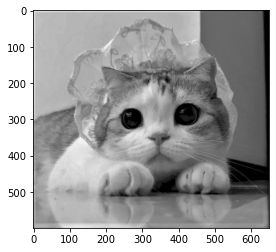

In [3]:
img = cv.imread('puff.png',cv.IMREAD_GRAYSCALE)
# img = np.flip(img,2)
plt.imshow(img,cmap='gray')

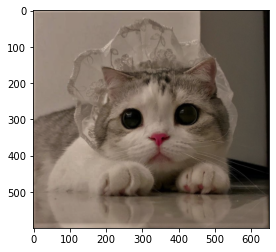

In [4]:
img1 = cv.imread('puff.png')
img1 = np.flip(img1,2)
plt.imshow(img1)

In [5]:
def plt_show(img1,img2):
    plt.figure(figsize = (10,10))
    plt.subplot(121);plt.imshow(img1,cmap='gray')
    plt.subplot(122);plt.imshow(img2,cmap='gray')
    plt.show()

In [6]:
def plt_show1(img1,img2):
    plt.figure(figsize = (10,10))
    plt.subplot(121);plt.imshow(img1)
    plt.subplot(122);plt.imshow(img2)
    plt.show()

### Noise Type

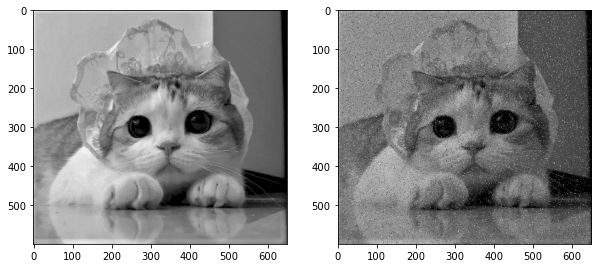

In [7]:
#salt&pepper noise
img_noise1 = skimage.util.random_noise(img,'s&p',amount = 0.05,salt_vs_pepper = 0.5)
plt_show(img,img_noise1)

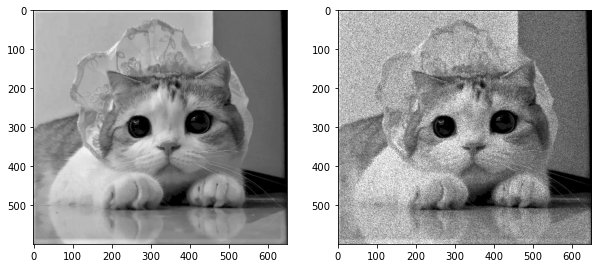

In [8]:
# speckle Noise
img_noise2 = skimage.util.random_noise(img,'speckle',mean = 0.3 , var = 0.1)
plt_show(img,img_noise2)

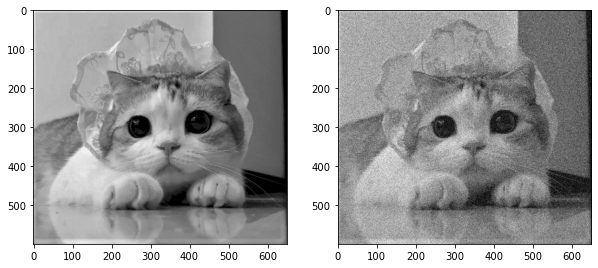

In [9]:
# gaussian
img_noise3 = skimage.util.random_noise(img,'gaussian',mean = 0.1 , var = 0.01)
plt_show(img,img_noise3)

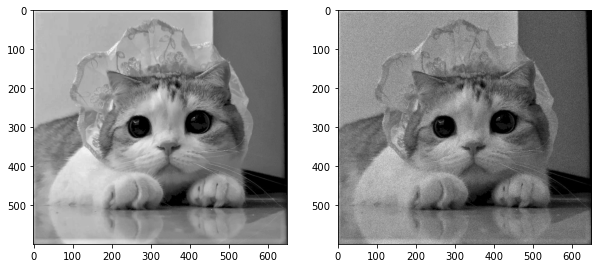

In [10]:
# poisson
img_noise4 = skimage.util.random_noise(img,'poisson')
plt_show(img,img_noise4)

# Low-pass filtering

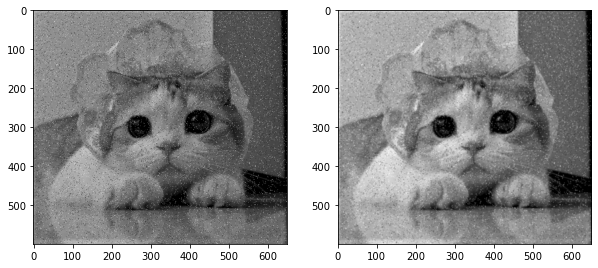

In [11]:
#linear low-pass filter
kernel_size = (3,3)
kernel = np.ones((kernel_size[0],kernel_size[1]))
kernel = kernel / kernel_size[0] / kernel_size[1]

img_filter1 = cv.filter2D(img_noise1,-1,kernel)
plt_show(img_noise1,img_filter1)

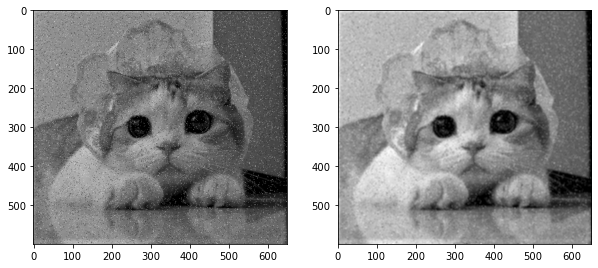

In [12]:
rows, cols = img_noise1.shape[0:2]

#Filter parameters
Q = 0
kernel_size = (5,5)
kernel = np.ones((kernel_size[0],kernel_size[1]))
kernel = kernel / kernel_size[0] / kernel_size[1]

#Convert to float and make image with border
if img_noise1.dtype == np.uint8:
    img_copy = img_noise1.astype(np.float32) / 255
else:
    img_copy = img_noise1
img_copy = cv.copyMakeBorder(img_copy,int((kernel_size[0] - 1) / 2), int(kernel_size[1] / 2),
                            int((kernel_size[0] - 1) / 2),int(kernel_size[1] / 2), cv.BORDER_REPLICATE)

#Calculate temporary matrices for I ** Q and I * * (Q + 1)
img_copy_power = np.power(img_copy, Q)
img_copy_power_1 = np.power(img_copy,Q + 1)

img_filter_top = np.zeros(img_noise1.shape, np.float32)
img_filter_bottom = np.zeros(img_noise1.shape,np.float32)

#Do filter
for i in range(kernel_size[0]):
    for j in range(kernel_size[1]):
        img_filter_top = img_filter_top + kernel[i, j] * img_copy_power_1[i:i + rows , j:j + cols]
        img_filter_bottom = img_filter_bottom + kernel[i, j] * img_copy_power[i: i + rows,j : j+ cols]
img_filter = img_filter_top / img_filter_bottom / np.sum(kernel) ** Q

#Convert back to uint if needed 
if(img_noise1.dtype == np.uint8):
    img_filter = (255 * img_filter).clip(0,255).astype(np.uint8)

plt_show(img_noise1,img_filter)

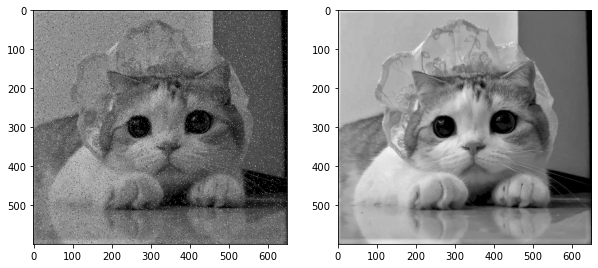

In [13]:
#Gaussian Filter
img_gauss = cv.GaussianBlur(img,ksize=(0,0),sigmaX = 0.1,borderType = cv.BORDER_REPLICATE)
plt_show(img_noise1,img_gauss)

# Nonlinear Filtering

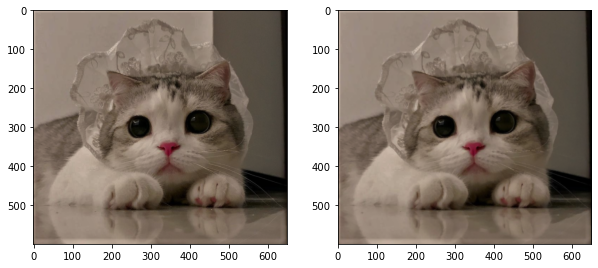

In [26]:
#Median Filtering
img_median = cv.medianBlur(img1,3)
plt_show(img1,img_median)

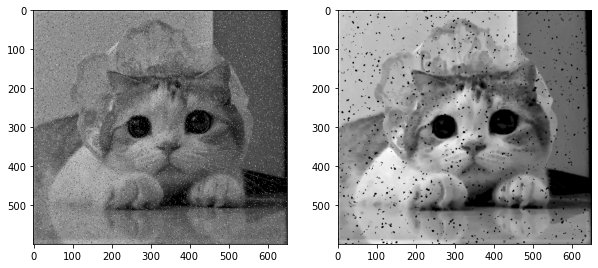

In [31]:
I = img_noise1
#weighted rank or median filtering

# Filter parameters
k_size = (5 , 5)
# change this parameter here
# 3*3 kernel's median should be 4
rank = 2
kernel = np . ones ( k_size , dtype = np . float32 )
rows , cols = I . shape [0:2]

#Convert to float and make image with border
if I.dtype == np.uint8:
    I_copy = I.astype(np.float32) / 255
else:
    I_copy = I
I_copy = cv.copyMakeBorder(I_copy,
                           int((k_size[0] - 1) / 2),
                           int((k_size[1] / 2)),
                           int((k_size[0] - 1) / 2),
                           int(k_size[1] / 2), cv.BORDER_REPLICATE)
               
# Fill arrays for each kernel item
I_layers = np.zeros(I.shape + 
                   (k_size[0] * k_size[1], ),
                   dtype = np.float32)
if I.ndim == 2:
    for i in range(k_size[0]):
        for j in range(k_size[1]):
            I_layers[:,:,i * k_size[1] + j] = kernel[i, j] * I_copy[i:i + rows, j:j + cols]
else:
    for i in range(k_size[0]):
        for j in range(k_size[1]):
            I_layers[:,:,:,i * k_size[1] + j] = kernel[i,j] * I_copy[i:i + rows,j:j + cols,:]

#Sort arrays
I_layers.sort()

#Choose layer with rank
if I.ndim == 2:
    I_out = I_layers[:,:,rank]
else:
    I_out = I_layers[:,:,:,rank]
    
#Convert back to uint if needed
if(I.dtype == np.uint8):
    I_out = (255 * I_out).clip(0,255).astype(np.uint8)
    
plt_show(I,I_out)

D:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
D:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in multiply


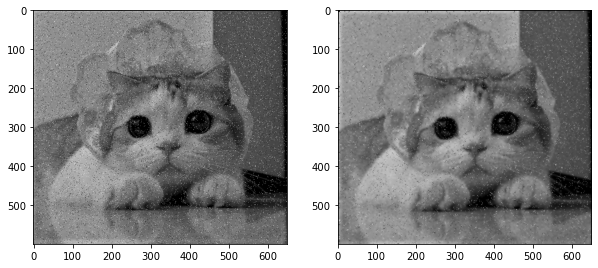

In [34]:
# Wiener filtering with OpenCV

I = img_noise1
# Define parameters
k_size = (5,5)
kernel = np . ones (( k_size [0] , k_size [1]))
# Convert to float and make image with border
if I . dtype == np . uint8 :
    img_copy = I . astype ( np . float32 ) / 255
else :
    img_copy_nb = I
    img_copy = cv . copyMakeBorder ( img_copy ,
                                    int (( k_size [0] - 1) / 2) ,
                                    int ( k_size [1] / 2) ,
                                    int (( k_size [0] - 1) / 2) ,
                                    int ( k_size [1] / 2) ,
                                    cv . BORDER_REPLICATE )

# Split into layers
bgr_planes = cv . split ( img_copy )
bgr_planes_2 = []

k_power = np . power ( kernel , 2)

# For all layers
for plane in bgr_planes:
    # Calculate temporary matrices for I ** 2
    plane_power = np . power ( plane , 2)

    m = np . zeros ( I . shape [0:2] , np . float32 )
    q = np . zeros ( I . shape [0:2] , np . float32 )

# Calculate variance values
for i in range ( k_size [0]):
    for j in range ( k_size [1]):
        m = m + kernel [i , j ] * plane [ i : i + rows , j : j + cols ]
        q = q + k_power [i , j ] * plane_power [ i : i + rows , j : j + cols ]
m = m / np . sum ( kernel )
q = q / np . sum ( kernel )
q = q - m * m

# Calculate noise as an average variance
v = np . sum ( q ) / I . size

#Do filter
plane_2 = plane [( k_size [0] - 1) // 2: \
                 ( k_size [0] - 1) // 2 + rows , \
                 ( k_size [1] - 1) // 2: \
                 ( k_size [1] - 1) // 2 + cols ]
plane_2 = np . where ( q < v , m ,
                      ( plane_2 - m ) * (1 - v / q ) + m )
bgr_planes_2 . append ( plane_2 )

# Merge image back
I_out = cv . merge ( bgr_planes_2 )

# Convert back to uint if needed
if ( I . dtype == np . uint8 ):
    I_out = (255 * I_out ). clip (0 , 255).astype ( np . uint8 )
    
plt_show(I,I_out)

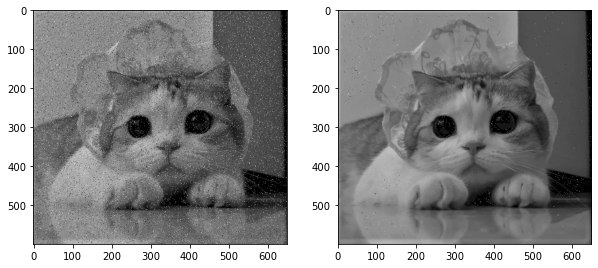

In [17]:
#Adaptive Median Filtering

rows,cols=img_noise1.shape[0:2]
bw=(img_noise1.ndim==2)
#set intital and maximum kernel sizes
kernel_size=(1,1)
max_kernel_size=7

#convert to float and make image with border
if img_noise1.dtype==np.uint8:
    img_copy_nb=img_noise1.astype(np.float32)/255
else:
    img_copy_nb=img_noise1
img_copy=cv.copyMakeBorder(img_copy_nb,int((max_kernel_size-1)/2),int(max_kernel_size/2),
                          int((max_kernel_size-1)/2),int(max_kernel_size/2),cv.BORDER_REPLICATE)
img_filter=np.zeros_like(img_copy_nb)
#mask of pixels to filter
mask=np.ones(img_noise1.shape,dtype=int)
#while there are not filter pixels
while mask.any() and kernel_size[0]<max_kernel_size:
    kernel_size=(kernel_size[0]+2,kernel_size[1]+2)
    kernel_shift=(int((max_kernel_size-kernel_size[0])/2),int((max_kernel_size-kernel_size[1])/2))
    kernel=np.ones((kernel_size[0],kernel_size[1]),dtype=np.float32)

    img_layers=np.zeros(img_noise1.shape+(kernel_size[0]*kernel_size[1], ),dtype=np.float32)
    if bw:
        for i in range(kernel_size[0]):
             for j in range(kernel_size[1]):
                    img_layers[:, :, i*kernel_size[1]+j]=kernel[i,j]* \
                    img_copy[i+kernel_shift[0]:i+kernel_shift[0]+rows,\
                             j+kernel_shift[1]:j+kernel_shift[1]+cols]
    else:
        for i in range(kernel_size[0]):
            for j in range(kernel_size[1]):
                img_layers[:, :, :, i * kernel_size[1] + j] = kernel[i, j] * \
                     img_copy[i + kernel_shift[0]:i + kernel_shift[0] + rows, \
                              j + kernel_shift[1]:j + kernel_shift[1] + cols, :]
     #sort kernels
    img_layers.sort()
    #calculate
    if bw:
        z_min=img_layers[:,:,0]
        z_mean=img_layers[:,:,int((kernel_size[0]*kernel_size[1]-1)/2)]
        z_max=img_layers[:, :,kernel_size[0]*kernel_size[1]-1]
    else:
        z_min = img_layers[:, :, :,0]
        z_mean = img_layers[:, :, :,int((kernel_size[0] * kernel_size[1] - 1) / 2)]
        z_max = img_layers[:, :, :,kernel_size[0] * kernel_size[1] - 1]
    #caluclate A and B
    A_mask=np.logical_and(z_min<z_mean,z_mean<z_max)
    B_mask=np.logical_and(z_min<img_copy_nb,img_copy_nb<z_max)
    #copy data that filfils the condition
    img_filter[np.logical_and(mask,np.logical_and(A_mask,B_mask))]= \
      img_copy_nb[np.logical_and(mask,np.logical_and(A_mask,B_mask))]
    img_filter[np.logical_and(mask,np.logical_and(A_mask,np.logical_not(B_mask)))]=\
      z_mean[np.logical_and(mask,np.logical_and(A_mask,np.logical_not(B_mask)))]
    #update mask with pixels that we copied
    mask=np.logical_and(mask,np.logical_not(A_mask))
#fill what left empty
img_filter[mask]=img_copy_nb[mask]
# #convert back to uint if needed
if(img_noise1.dtype==np.uint8):
    img_filter=(255*img_filter).clip(0,255).astype(np.uint8)
    
# cv.imshow("Adaptive Median Filtering",img_filter)

plt_show(img_noise1,img_filter)


# High-Pass Filtering

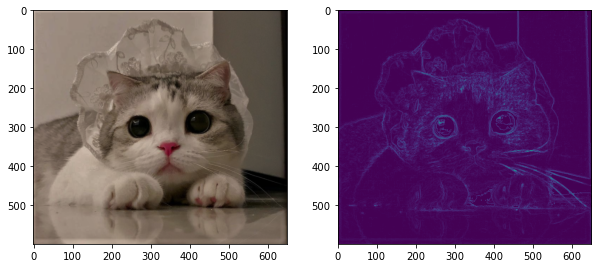

In [36]:
# Roberts Filtering
kernel_x = np.array([[1,-1],[0,0]])
kernel_y = np.array([[1,0],[-1,0]])

#Convert to float
if img1.dtype == np.uint8:
    img_filter = img.astype(np.float32) / 255
else:
    img_filter = np.copy(img)

#Perform convolution
img_x = cv.filter2D(img_filter,-1,kernel_x)
img_y = cv.filter2D(img_filter,-1,kernel_y)
img_filter = cv.magnitude(img_x,img_y)

#Convert back to uint if needed
if img.dtype == np.uint8:
    img_filter = (255 * img_filter).clip(0,255).astype(np.uint8)

plt.figure(figsize = (10,10))
plt.subplot(121);plt.imshow(img1)
plt.subplot(122);plt.imshow(img_filter)
plt.show()

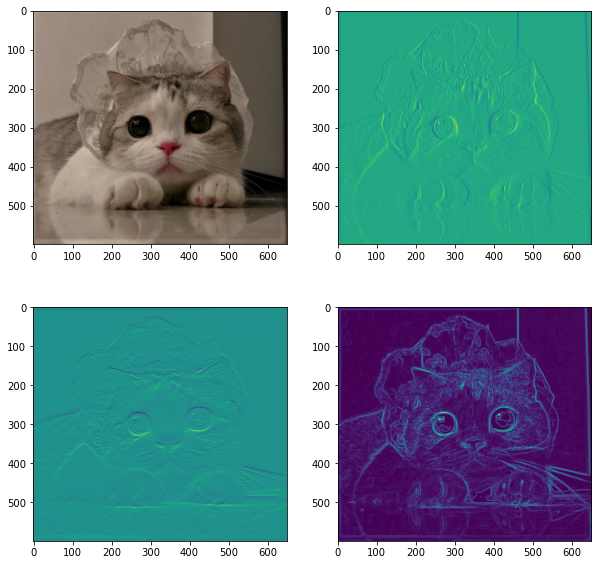

In [37]:
# Prewitt Filter
kernel_x = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
kernel_y = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])

#Convert to float
if img1.dtype == np.uint8:
    img_filter = img.astype(np.float32) / 255
else:
    img_filter = np.copy(img)

#Perform convolution
img_x = cv.filter2D(img_filter,-1,kernel_x)
img_y = cv.filter2D(img_filter,-1,kernel_y)
img_filter = cv.magnitude(img_x,img_y)

#Convert back to uint if needed
if img.dtype == np.uint8:
    img_filter = (255 * img_filter).clip(0,255).astype(np.uint8)

plt.figure(figsize = (10,10))
plt.subplot(221);plt.imshow(img1)
plt.subplot(222);plt.imshow(img_x)
plt.subplot(223);plt.imshow(img_y)
plt.subplot(224);plt.imshow(img_filter)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


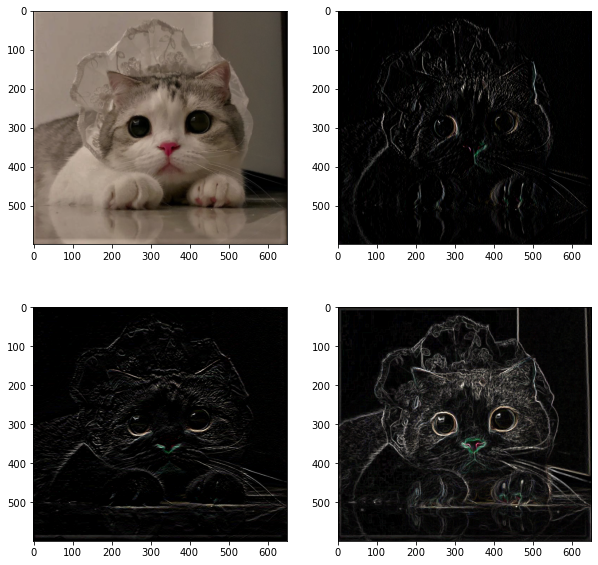

In [20]:
 #Sobel Filtering
kernel_x = np.array([[-1,0,-1],[-2,0,2],[-1,0,1]])
kernel_y = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

#Convert to float
if img1.dtype == np.uint8:
    img_filter = img1.astype(np.float32) / 255
else:
    img_filter = np.copy(img1)

#Perform convolution
img_x = cv.Sobel(img_filter,cv.CV_64F,1,0)
img_y = cv.Sobel(img_filter,cv.CV_64F,0,1)
img_filter = cv.magnitude(img_x,img_y)

#Convert back to uint if needed
if img.dtype == np.uint8:
    img_filter = (255 * img_filter).clip(0,255).astype(np.uint8)

plt.figure(figsize = (10,10))
plt.subplot(221);plt.imshow(img1)
plt.subplot(222);plt.imshow(img_x)
plt.subplot(223);plt.imshow(img_y)
plt.subplot(224);plt.imshow(img_filter)
plt.show()

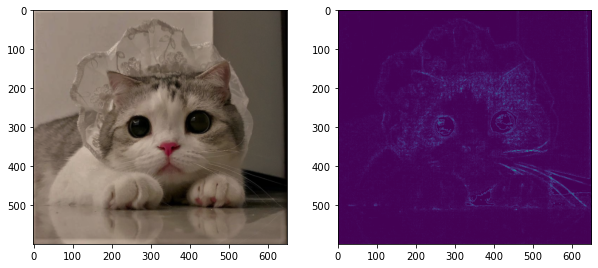

AxisError: axis 2 is out of bounds for array of dimension 2

In [38]:
#Laplace Filter
kernel = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])

#Convert to float
if img1.dtype == np.uint8:
    img_filter = img.astype(np.float32) / 255
else:
    img_filter = np.copy(img)

#Perform convolution
# img_filter = cv.filter2D(img_filter,-1,kernel)
img_filter = cv.Laplacian(img_filter,cv.CV_32F)

if img.dtype == np.uint8:
    img_filter = (255 * np.abs(img_filter)).clip(0,255).astype(np.uint8)

plt.figure(figsize = (10,10))
plt.subplot(121);plt.imshow(img1)
plt.subplot(122);plt.imshow(img_filter)
plt.show()

cv_show('lap',img_filter)

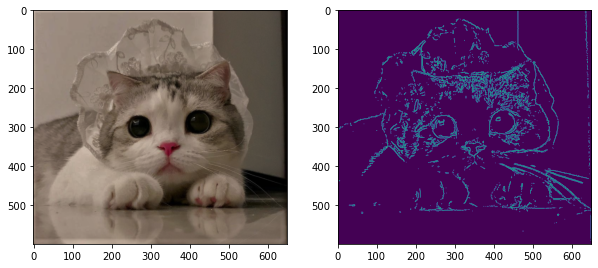

In [22]:
# Canny Algorithm
img_filter = cv.Canny(img1,100,100)
plt.figure(figsize = (10,10))
plt.subplot(121);plt.imshow(img1)
plt.subplot(122);plt.imshow(img_filter)
plt.show()